### Predictions

#### 4 beeps

In [1]:
import matplotlib.pyplot as plt
import itertools


def plot_neural_input(res, position=15):
    plt.plot(res.e_.auditory_total_input[:, position], label="Auditory")
    plt.plot(res.e_.visual_total_input[:, position], label="Visual")
    plt.plot(res.e_.multi_total_input[:, position], label="Multisensory")
    plt.ylabel("Neural input", size=14)
    plt.xlabel("Time", size=14)
    plt.legend()
    plt.show()


def plot_res_per_soa(result_list, position=15):
    fig, axs = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)
    idx = -1
    for res in result_list:
        idx += 1
        row, col = idx // 5, idx % 5
        sub_plot = res.plot.linet(position=15, ax=axs[row, col])
        sub_plot.get_legend().remove()
        sub_plot.set_title("SOA " + str(int(res.run_params.soa)) + " ms")

    handles, labels = sub_plot.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", borderaxespad=0.1)
    plt.subplots_adjust(right=0.935)
    plt.show()


def calculate_two_peaks_probability(visual_peaks_values):
    combinations = list(
        itertools.chain.from_iterable(
            itertools.combinations(visual_peaks_values, i + 2)
            for i in range(len(visual_peaks_values))
        )
    )

    probs_array = np.array([])

    for i in combinations:
        probs_array = np.append(probs_array, np.array(i).prod())

    return probs_array.sum() / probs_array.size

In [161]:
from skneuromsi.neural import Paredes2022
from joblib import Parallel, delayed
import numpy as np
from findpeaks import findpeaks
from skneuromsi.utils import storages
import os
from scipy.stats import uniform


def myjob_explore_beeps(
    soa,
    beeps_range,
    l_ex,
    fb_weight,
    cm_weight,
    ff_weight,
    a_tau,
    v_tau,
    m_tau,
    ff_pruning_threshold,
    cm_pruning_threshold,
    storage,
    storage_idx,
):
    visual_peak_count = []

    model = Paredes2022(
        time_range=(0, 800),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    for n_beeps in beeps_range:
        res = model.run(
            soa=soa,
            auditory_stim_n=n_beeps,
            auditory_intensity=2.425,  # 2.425
            visual_intensity=1.375,  # 1.375
            visual_stim_n=1,
            auditory_duration=7,
            visual_duration=12,
            auditory_onset=10,
            visual_onset=34,
            cross_modal_weight=cm_weight,
            feedback_weight=fb_weight,
            feedforward_weight=ff_weight,
            lateral_excitation=l_ex,
            feedforward_pruning_threshold=ff_pruning_threshold,
            cross_modal_pruning_threshold=cm_pruning_threshold,
            noise=False,
            temporal_noise=True,
            temporal_noise_scale=5,
        )

        fp = findpeaks(method="topology", verbose=0, limit=0.40)
        fp_results = fp.fit(
            res.get_modes("visual").query("positions==15").visual.values
        )
        visual_peaks_df = fp_results["df"].query("peak==True & valley==False")

        # multi_fp_results = fp.fit(res.get_modes("multi").query("positions==15").multi.values)
        # multi_peaks_df = multi_fp_results["df"].query("peak==True & valley==False")

        visual_peak_count.append(visual_peaks_df["score"].size)
    storage[storage_idx] = visual_peak_count

In [162]:
soa = 48
n_sims = 30
beeps_range = np.arange(1, 5)

flashes_res = []
causes_res = []

sim_storage = storages.DirectoryStorage(size=n_sims, tag="beeps")
with Parallel(n_jobs=-3) as parallel:
    parallel(
        delayed(myjob_explore_beeps)(
            soa,
            beeps_range,
            1.6,
            2.423e-01,
            1.327e-02,
            2.461e00,
            6.712e00,
            2.356e01,
            1.175e02,
            0,
            0,
            sim_storage,
            sim,
        )
        for sim in range(n_sims)
    )

flashes = np.array(sim_storage)
flashes_per_beep = flashes.mean(axis=0)

sim_storage_scz = storages.DirectoryStorage(size=n_sims, tag="beeps_scz")
with Parallel(n_jobs=-3) as parallel:
    parallel(
        delayed(myjob_explore_beeps)(
            soa,
            beeps_range,
            1.632e00,
            2.423e-01,
            1.327e-02,
            2.461e00,
            6.712e00,
            2.356e01,
            1.175e02,
            0,
            0,
            sim_storage_scz,
            sim,
        )
        for sim in range(n_sims)
    )

flashes_scz = np.array(sim_storage_scz)
flashes_per_beep_scz = flashes_scz.mean(axis=0)

In [163]:
flashes_per_beep

array([1.33333333, 1.7       , 1.76666667, 1.86666667])

In [164]:
flashes_per_beep_scz

array([1.56666667, 1.73333333, 1.73333333, 1.9       ])

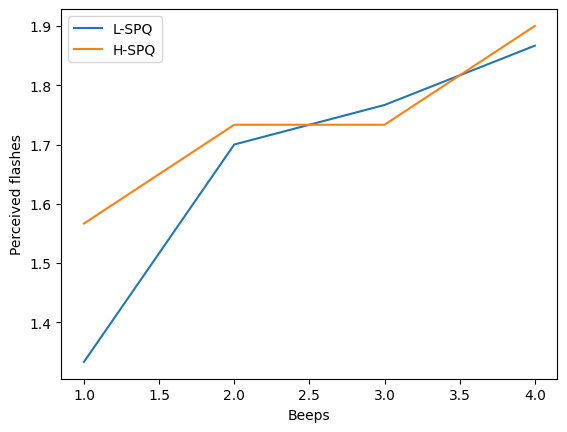

In [165]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(beeps_range, flashes_per_beep, label="L-SPQ")
plt.plot(beeps_range, flashes_per_beep_scz, label="H-SPQ")
plt.ylabel("Perceived flashes")
plt.xlabel("Beeps")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(beeps, flashes_res)
plt.ylabel("Perceived flashes")
plt.xlabel("Beeps")

plt.figure(2)
plt.plot(beeps, causes_res)
plt.ylabel("Perceived causes")
plt.xlabel("Beeps")

lex_4b = np.asarray([beeps, flashes_res, causes_res])
np.save("lex_4b.npy", lex_4b)

In [ ]:
from joblib import Parallel, delayed
import numpy as np
from scipy.signal import find_peaks
from skneuromsi.neural import Paredes2022


def myjob(soa, n_sims, n_beeps):
    visual_peak_count = []
    peak_count = []
    for sim in range(n_sims):
        model = Paredes2022(time_range=(0, 400), neurons=30, position_range=(0, 30))
        res = model.run(
            lateral_excitation=2.15,
            auditory_intensity=2.4,
            visual_intensity=1.4,
            auditory_stim_n=n_beeps,
            visual_stim_n=1,
            auditory_duration=7,
            visual_duration=12,
            soa=soa,
            noise=True,
            noise_level=0.4,
            cross_modal_weight=0.075,
        )
        visual_peaks_idx, _ = find_peaks(
            x=res.get_modes("visual").query("positions==15").visual.values,
            height=0.40,
            prominence=0.15,
        )
        peaks = res.causes_
        peak_count.append(peaks)
        visual_peaks = np.size(visual_peaks_idx)
        visual_peak_count.append(visual_peaks)
    return peak_count, visual_peak_count


soa = np.array([48])
sims = 100
beeps = np.arange(1, 5)
flashes_res = []
causes_res = []

for j in beeps:
    with Parallel(n_jobs=-1) as parallel:
        res = parallel(delayed(myjob)(i, sims, j) for i in soa)
    causes = [i[0] for i in res]
    flashes = [i[1] for i in res]

    avg_causes = np.mean(causes)
    avg_flashes = np.mean(flashes)
    causes_res.append(avg_causes)
    flashes_res.append(avg_flashes)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(beeps, flashes_res)
plt.ylabel("Perceived flashes")
plt.xlabel("Beeps")

plt.figure(2)
plt.plot(beeps, causes_res)
plt.ylabel("Perceived causes")
plt.xlabel("Beeps")

base_4b = np.asarray([beeps, flashes_res, causes_res])
np.save("base_4b.npy", base_4b)

#### Plot

In [ ]:
from sklearn.preprocessing import normalize
import string

lex_4b = np.load("lex_4b.npy")
base_4b = np.load("base_4b.npy")

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5), dpi=600)
size = 5

ax1 = plt.subplot(121)
ax1.plot(lex_4b[0], lex_4b[1], label=r"$L_{ex}^{s} = 2.25$", color="k", marker="^")
ax1.plot(base_4b[0], base_4b[1], label=r"$L_{ex}^{s} = 2$", color="k", marker="o")
# ax1.plot(np.linspace(0,.75,size),np.repeat(70.38,size),'--',label='SCZ',color='0.5')
# ax1.plot(np.linspace(0,.75,size),np.repeat(73.75,size),':',label='H-SPQ',color='0.5')
ax1.set_ylabel("Perceived flashes", size=14)
ax1.set_xlabel("Beeps", size=14)
leg = ax1.legend(fontsize=13)
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2 = plt.subplot(122)
ax2.plot(lex_4b[0], lex_4b[2], label=r"$L_{ex}^{s} = 2.25$", color="k", marker="^")
ax2.plot(base_4b[0], base_4b[2], label=r"$L_{ex}^{s} = 2.15$", color="k", marker="o")
ax2.set_ylabel("Perceived causes", size=14)
ax2.set_xlabel("Beeps", size=14)
leg = ax2.legend(fontsize=13)
ax2.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

# fig.savefig('FIG5.eps', bbox_inches='tight', format = 'eps')